In [25]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras.layers import Layer, Input, Flatten, Embedding, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, MultiHeadAttention, LayerNormalization, Add
from keras import layers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os
import warnings
import pdb

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')

keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4622005554165482476
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2740060160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12543317069732273582
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2023-03-15 02:54:53.626950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 02:54:53.627650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 02:54:53.628027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 02:54:53.628581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 02:54:53.629147: I tensorflow/compiler/xla/stream_executo

In [2]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-15 02:24:02.166137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 02:24:02.166773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 02:24:02.167398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

2023-03-15 02:24:04.056142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 02:24:04.057165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 02:24:04.057837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 02:24:04.058578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 02:24:04.059122: I tensorflow/compiler/xla/stream_executo

In [4]:
DATAPATH = './lenses'
OUTPATH = './output'
os.makedirs(OUTPATH, exist_ok=True)
CATEGORIES = ('no_sub', 'sub')

In [8]:
def load_data(root, categories):
    x, y = [], []

    for index, category in enumerate(categories):
        for filename in os.scandir(os.path.join(root, category)):
            filedata = np.asarray(Image.open(filename.path))
            x.append(filedata)
            y.append(index)
  
    x = np.expand_dims(np.array(x), axis=-1)
    y = np.array(y)

    return x, y

In [9]:
X, Y = load_data(DATAPATH, CATEGORIES)

print(f'Shape of X: {X.shape}')
print(f'Shape of Y: {Y.shape}')

Shape of X: (10000, 150, 150, 1)
Shape of Y: (10000,)


In [10]:
permutations = np.random.permutation(len(X))
X, Y = X[permutations], Y[permutations]

val_size = len(X) // 10
X_TRAIN, Y_TRAIN = X[val_size:], Y[val_size:]
X_VAL, Y_VAL = X[:val_size], Y[:val_size]

print(f'X_TRAIN shape: {X_TRAIN.shape}')
print(f'X_VAL shape: {X_VAL.shape}')

X_TRAIN shape: (9000, 150, 150, 1)
X_VAL shape: (1000, 150, 150, 1)


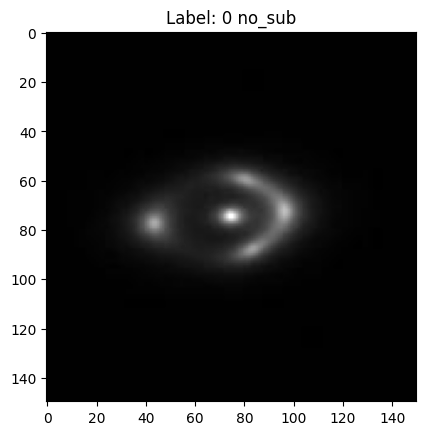

In [11]:
index = np.random.default_rng().integers(0, len(X_TRAIN))
ax = plt.imshow(X_TRAIN[index].squeeze(), cmap='gray')
ax1 = plt.title(f'Label: {Y_TRAIN[index]} {CATEGORIES[Y_TRAIN[index]]}')

In [12]:
pos_neg_ratio = len(Y_TRAIN[Y_TRAIN == 1]) / len(Y_TRAIN[Y_TRAIN == 0])
print(f'Positive/Negative class ratio in train set: {pos_neg_ratio}')
if abs(pos_neg_ratio - 1) < 0.01:
    print('class imbalance not present.')
else:
    print('class imbalance present!')

Positive/Negative class ratio in train set: 0.9964507542147294
class imbalance not present.


In [13]:
def standardize(x, datatype, root):
    x = x - np.mean(x, axis=(1, 2), keepdims=True)
  
    
    mean = np.mean(x, axis=(0, 1, 2), keepdims=True)
    std = np.std(x, axis=(0, 1, 2), keepdims=True)
    np.save(os.path.join(root, 'mean'), mean)
    np.save(os.path.join(root, 'std'), std)
    
    x = (x - mean) / std
    return x

In [14]:
X_TRAIN = standardize(X_TRAIN, 'train', OUTPATH)
X_VAL = standardize(X_VAL, 'val', OUTPATH)

In [15]:
class Patches(Layer):
    def __init__(self, patch_size, num_channels=1, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.num_channels = num_channels

    def call(self, images, training=None):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, self.num_channels],
            strides=[1, self.patch_size, self.patch_size, self.num_channels],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patches = tf.reshape(patches,[tf.shape(patches)[0], -1, tf.shape(patches)[-1]])
        return patches

In [17]:
class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches,
                                            output_dim=projection_dim)

    def call(self, patch, training=None):
        positions = tf.range(0, self.num_patches)
        # Add patch embeddings and position embeddings
        encoded = (self.projection(patch, training=training) +
                   self.position_embedding(positions, training=training))
        return encoded

In [18]:
class FFN(Layer):
    def __init__(self, hidden_units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.layers = [Dense(units, activation=tf.nn.gelu) for units in hidden_units]
        self.dropout_rate = dropout_rate
  
    def call(self, x, training=None):
        for layer in self.layers:
            x = layer(x, training=training)
            x = Dropout(self.dropout_rate)(x, training=training)
        return x

In [20]:
class Transformer(Layer):
    def __init__(self, transformer_units, num_heads, projection_dim,
                 epsilon=1e-6, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.norm1 = LayerNormalization(epsilon=epsilon)
        self.attention = MultiHeadAttention(num_heads=num_heads,
                                            key_dim=projection_dim,
                                            dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=epsilon)
        self.ffn = FFN(transformer_units, dropout_rate)
  
    def call(self, encoded_patch, training=None):
        x1 = self.norm1(encoded_patch, training=training)
        attention_output = self.attention(x1, x1, training=training)
        x2 = Add()([attention_output, encoded_patch])
        x3 = self.norm2(x2, training=training)
        x3 = self.ffn(x3, training=training)
        output = Add()([x3, x2])
        return output

In [21]:
class ViTClassifier(keras.Model):
    def __init__(self, patch_size, num_patches, projection_dim, mlp_head_units,
                 num_transformer_layers, transformer_units, num_heads,
                 dropout_rate=0.5, transformer_dropout_rate=0.1, epsilon=1e-6,
                 **kwargs):
        super().__init__(**kwargs)
        self.augment = keras.Sequential(
            [RandomFlip(),
             RandomRotation(0.5),
             RandomZoom(height_factor=0.2, width_factor=0.2)],
            name='augment'
        )

        self.patch = Patches(patch_size)
        self.patch_encoder = PatchEncoder(num_patches, projection_dim)
        self.transformers = keras.Sequential(
            [Transformer(transformer_units, num_heads, projection_dim,
                         epsilon=epsilon, dropout_rate=transformer_dropout_rate)
            for _ in range(num_transformer_layers)],
            name='transformers'
        )
        self.norm = LayerNormalization(epsilon=epsilon)
        self.dropout_rate = dropout_rate
        self.mlp_head = FFN(mlp_head_units, dropout_rate, name='mlp_head')
        self.classify = Dense(1, activation='sigmoid', name='classifier')
  
    def call(self, image, training=None):
        image = self.augment(image, training=training)

        patches = self.patch(image, training=training)
        patches = self.patch_encoder(patches, training=training)

        patches = self.transformers(patches, training=training)

        representation = self.norm(patches, training=training)
        representation = Flatten()(representation)
        representation = Dropout(self.dropout_rate)(representation, training=training)
        representation = self.mlp_head(representation, training=training)
        output = self.classify(representation, training=training)

        return output

In [22]:
class RandomSampleGenerator(keras.utils.Sequence):
    def __init__(self, x, y, batch_size, seed=None):
        self.x_positive = x[y == 1]
        self.y_positive = y[y == 1]

        self.x_negative = x[y == 0]
        self.y_negative = y[y == 0]

        self.epoch_length = len(x) // batch_size
        self.batch_size = batch_size
        self.seed = seed
        self.reset()

    def reset(self):
        self.rng = np.random.default_rng(self.seed)

    def __len__(self):
        return self.epoch_length

    def __getitem__(self, idx):
        batch_positive_indices = self.rng.choice(self.x_positive.shape[0],
                                                 self.batch_size // 2,
                                                 replace=False)
        batch_x_positive = self.x_positive[batch_positive_indices]
        batch_y_positive = self.y_positive[batch_positive_indices]

        batch_negative_indices = self.rng.choice(self.x_negative.shape[0],
                                                 int(np.ceil(self.batch_size / 2)),
                                                 replace=False)
        batch_x_negative = self.x_negative[batch_negative_indices]
        batch_y_negative = self.y_negative[batch_negative_indices]

        batch_x = np.concatenate((batch_x_positive, batch_x_negative))
        batch_y = np.concatenate((batch_y_positive, batch_y_negative))

        return batch_x, batch_y

In [23]:
class TrackBestPerformance(keras.callbacks.Callback):
    def __init__(self, ckp_path, save_every=15, **kwargs):
        super().__init__(**kwargs)
        self.best_auc = 0
        self.best_epoch = -1
        self.best_weights = None
        self.ckp_path = ckp_path
        self.save_every = save_every
  
    def on_epoch_end(self, epoch, logs=None):
        current_auc = logs['val_auc']
        if current_auc >= self.best_auc:
            self.best_auc = current_auc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()
        if epoch % self.save_every == 0:
            self.model.save_weights(self.ckp_path)
  
    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)
        self.model.save_weights(self.ckp_path)
        print(f'\nBest validation AUC is {self.best_auc} '
              f'on epoch #{self.best_epoch + 1}')

In [27]:

BATCH_SIZE = 64
EPOCHS = 40
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

IMAGE_SIZE = X_TRAIN.shape[1]
PATCH_SIZE = 15
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

PROJECTION_DIM = 64
NUM_HEADS=4   

TRANSFORMER_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]
NUM_TRANSFORMER_LAYERS = 8   
MLP_HEAD_UNITS = [2048, 1024] 

In [28]:
model = ViTClassifier(
    patch_size=PATCH_SIZE, num_patches=NUM_PATCHES,
    projection_dim=PROJECTION_DIM, mlp_head_units=MLP_HEAD_UNITS,
    num_transformer_layers=NUM_TRANSFORMER_LAYERS,
    transformer_units=TRANSFORMER_UNITS, num_heads=NUM_HEADS
)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tfa.optimizers.AdamW(learning_rate=LEARNING_RATE,
                                             weight_decay=WEIGHT_DECAY),
              metrics=keras.metrics.AUC(name='auc'))


In [29]:
train_generator = RandomSampleGenerator(X_TRAIN, Y_TRAIN, BATCH_SIZE, seed=42)


history = model.fit(train_generator, validation_data=(X_VAL, Y_VAL), epochs=EPOCHS, verbose=2)

Epoch 1/40
140/140 - 88s - loss: 1.0607 - auc: 0.5017 - val_loss: 0.6905 - val_auc: 0.6032 - 88s/epoch - 626ms/step
Epoch 2/40
140/140 - 74s - loss: 0.7144 - auc: 0.5101 - val_loss: 0.6908 - val_auc: 0.6174 - 74s/epoch - 529ms/step
Epoch 3/40
140/140 - 75s - loss: 0.7019 - auc: 0.5330 - val_loss: 0.6842 - val_auc: 0.6842 - 75s/epoch - 532ms/step
Epoch 4/40
140/140 - 75s - loss: 0.6983 - auc: 0.5316 - val_loss: 0.6899 - val_auc: 0.6546 - 75s/epoch - 538ms/step
Epoch 5/40
140/140 - 76s - loss: 0.6931 - auc: 0.5441 - val_loss: 0.6835 - val_auc: 0.6329 - 76s/epoch - 540ms/step
Epoch 6/40
140/140 - 77s - loss: 0.6851 - auc: 0.5706 - val_loss: 0.6690 - val_auc: 0.6548 - 77s/epoch - 553ms/step
Epoch 7/40
140/140 - 76s - loss: 0.6653 - auc: 0.6110 - val_loss: 0.6238 - val_auc: 0.7645 - 76s/epoch - 541ms/step
Epoch 8/40
140/140 - 75s - loss: 0.6319 - auc: 0.6724 - val_loss: 0.6906 - val_auc: 0.6118 - 75s/epoch - 535ms/step
Epoch 9/40
140/140 - 75s - loss: 0.5945 - auc: 0.7197 - val_loss: 0.4600

In [30]:
best_epoch_idx = np.argmax(history.history['val_auc'])

print('Best validation AUC: {:.3%}'.format(history.history['val_auc'][best_epoch_idx]))
print('Corresponding train AUC: {:.3%}'.format(history.history['auc'][best_epoch_idx]))

Best validation AUC: 99.144%
Corresponding train AUC: 96.310%


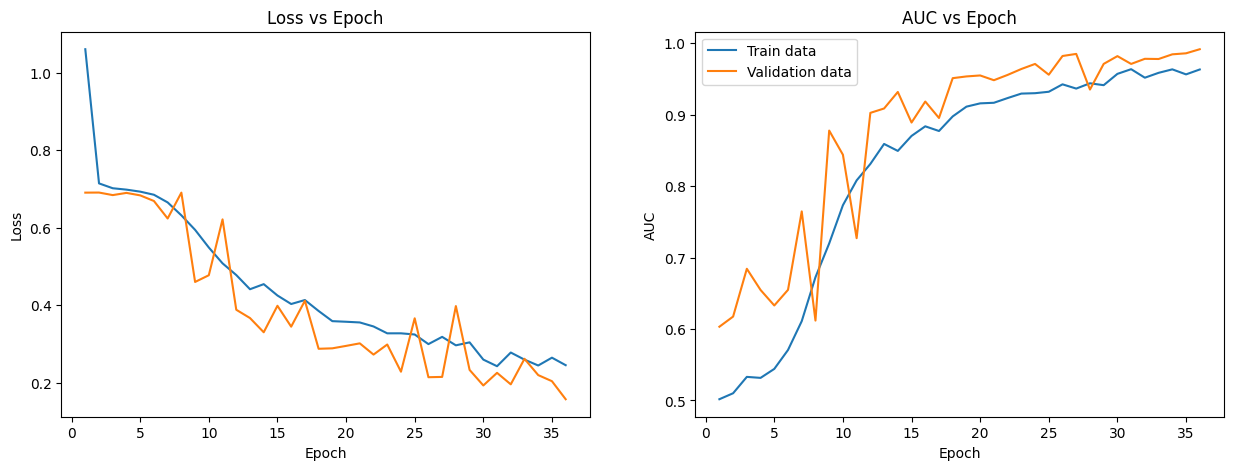

In [31]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
_ = axes[0].plot(range(1, best_epoch_idx + 2),
                  history.history['loss'][:best_epoch_idx + 1],
                  label='Train data')
_ = axes[0].plot(range(1, best_epoch_idx + 2),
                  history.history['val_loss'][:best_epoch_idx + 1],
                  label='Validation data')
_ = axes[0].set(xlabel='Epoch', ylabel='Loss', title='Loss vs Epoch')
_ = axes[1].plot(range(1, best_epoch_idx + 2),
                  history.history['auc'][:best_epoch_idx + 1],
                  label='Train data')
_ = axes[1].plot(range(1, best_epoch_idx + 2),
                 history.history['val_auc'][:best_epoch_idx + 1],
                  label='Validation data')
_ = axes[1].set(xlabel='Epoch', ylabel='AUC', title='AUC vs Epoch')
_ = plt.legend()

In [32]:
!pushd {OUTPATH}; zip -rq test_5_weights.zip weights; popd

/bin/bash: /home/ubuntu/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
~/GSoC23/deeplense/test_V/output ~/GSoC23/deeplense/test_V

zip error: Nothing to do! (try: zip -rq test_5_weights.zip . -i weights)
~/GSoC23/deeplense/test_V


In [33]:
def split_and_predict(x, num_batches=50):
    x_batches = np.array_split(x, num_batches)
    y_pred = np.concatenate([model(x_batch).numpy() for x_batch in x_batches], axis=0)[:, 0]
    return y_pred

In [34]:
Y_PRED_TRAIN = split_and_predict(X_TRAIN)
Y_PRED_VAL = split_and_predict(X_VAL)

In [35]:
def plot_roc_curve(y, y_pred, axis, label=None, num_thresholds=200):
    thresholds = np.linspace(0., 1., num_thresholds)

    trp, falp, trn, faln = [], [], [], []

    for threshold in thresholds:
        y_pred_label = (y_pred > threshold).astype(int)
        trp.append(np.count_nonzero(((y_pred_label == 1) & (y == 1)), axis=0))
        falp.append(np.count_nonzero(((y_pred_label == 1) & (y == 0)), axis=0))
        trn.append(np.count_nonzero(((y_pred_label == 0) & (y == 0)), axis=0))
        faln.append(np.count_nonzero(((y_pred_label == 0) & (y == 1)), axis=0))

    trp, falp, trn, faln = np.array(trp), np.array(falp), np.array(trn), np.array(faln)

    tp_rate = trp / (trp + faln)
    fp_rate = falp / (falp + trn)

    _ = axis.plot(fp_rate, tp_rate, label=label)

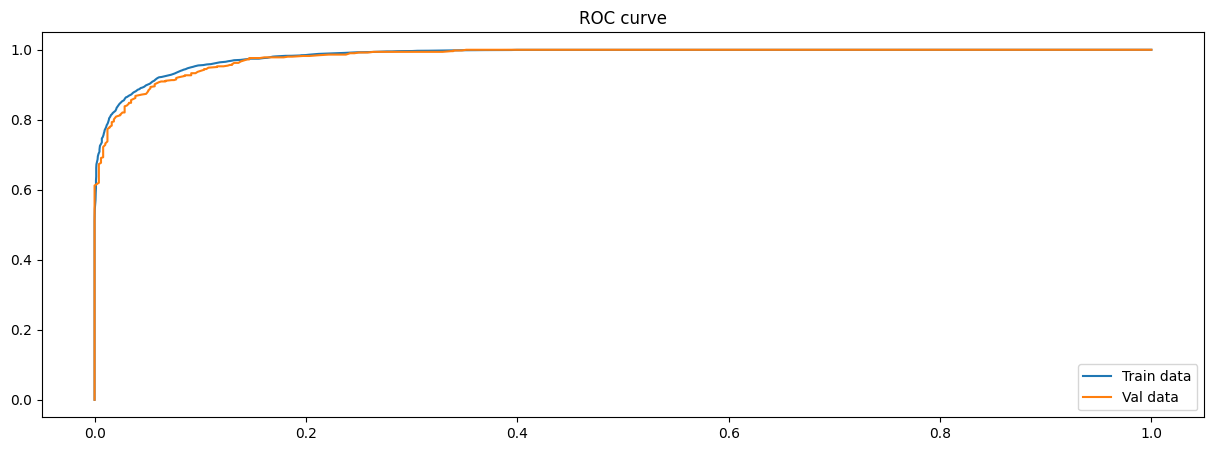

In [36]:
fig, axis = plt.subplots(figsize=(15, 5))

plot_roc_curve(Y_TRAIN, Y_PRED_TRAIN, axis, 'Train data')

plot_roc_curve(Y_VAL, Y_PRED_VAL, axis, 'Val data')

_ = axis.set(title='ROC curve')
_ = plt.legend()